# Employee Retention

In [54]:
#Import data and necessary libraries
import pandas as pd
import numpy as np
import datetime
import os
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline

working_dir = os.getcwd()
employee_data = pd.read_csv(os.path.join(working_dir,"data/employee_retention_data.csv"), index_col = 0)

#Check if each row is a unique employee id
if len(employee_data) == len(employee_data.index.unique()):
    print("Each row represents a unique employee ID")

Each row represents a unique employee ID


In [55]:
#Variable for how long employee has been at company
#If still works there, assume tenure is from start date until 12/13/2015 (per data challenge description)

todays_date = pd.to_datetime(datetime.date(2015, 12, 13))

def tenure_quit(row):
    if pd.isnull(row['quit_date']):
        tenure = pd.to_datetime(todays_date) - pd.to_datetime(row['join_date'])
    else: 
        tenure = pd.to_datetime(row['quit_date']) - pd.to_datetime(row['join_date'])
    return(tenure)

employee_data['tenure'] = employee_data.apply(tenure_quit, axis=1)

#Binary flag for quitting and numerical tenure
employee_data['quit_binary'] = np.where(pd.isnull(employee_data.quit_date),0,1)
employee_data['tenure_int'] = round(pd.to_numeric(employee_data.tenure)/1e14)

## EDA

#### From the EDA below, the following becomes clear:
1. The proportion of employees that quit is similiar across companies (around 50%), except company 11 where it is higher (closer to 80%)
2. In aggregate, the proprtion of employees that quit is similiar across department, seniority, and salary level.
3. Looking at time until an employee quits (i.e., duration of employement), many employees seem to quit after 1 year, and then again after year 2, regardless of salary or seniority. Therefore, this problem is best modelled as a survival analysis (i.e., time to event), which I explore in the next section

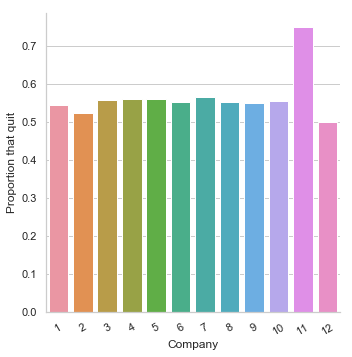

In [56]:
#Look at quit rates by company 
ax = sns.catplot(x="company_id", y='quit_binary', data=employee_data.groupby('company_id').agg('mean').reset_index(), kind="bar")
ax.set(xlabel='Company', ylabel='Proportion that quit')
ax.set_xticklabels(rotation=30)

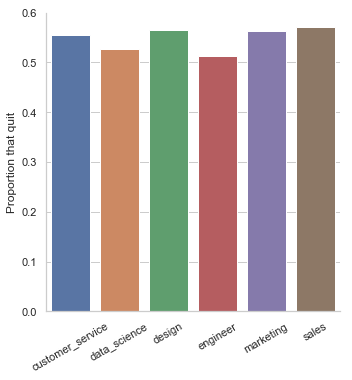

In [57]:
#Look at quit rates by department 
ax = sns.catplot(x="dept", y='quit_binary', data=employee_data.groupby('dept').agg('mean').reset_index(), kind="bar")
ax.set(xlabel='', ylabel='Proportion that quit')
ax.set_xticklabels(rotation=30)

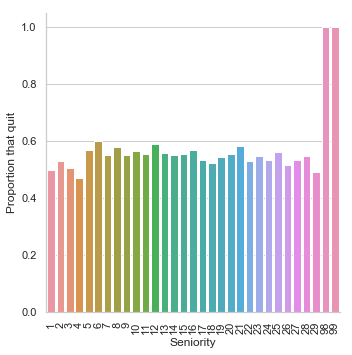

In [58]:
#Look at quit rates by seniority 
ax = sns.catplot(x="seniority", y='quit_binary', data=employee_data.groupby('seniority').agg('mean').reset_index(), kind="bar")
ax.set(xlabel='Seniority', ylabel='Proportion that quit')
ax.set_xticklabels(rotation=90)

In [59]:
#Seniority is missing for two records (set at 99 and 98 years, which cannot be accurate)
#Take these records out
employee_data = employee_data[(employee_data.seniority != 98) & (employee_data.seniority != 99)]

[<matplotlib.text.Text at 0x11b901da0>, <matplotlib.text.Text at 0x11b093860>]

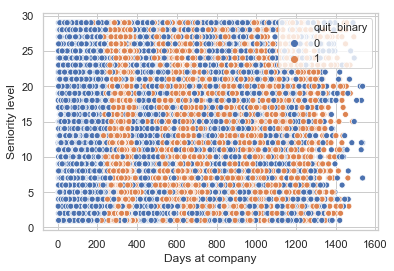

In [60]:
#Seniority and days at company scatterplot
ax = sns.scatterplot(x =round(pd.to_numeric(employee_data.tenure)/1e14), y='seniority', hue='quit_binary', data=employee_data)
ax.set(xlabel='Days at company', ylabel='Seniority level')

[<matplotlib.text.Text at 0x11b778978>, <matplotlib.text.Text at 0x11b91b2e8>]

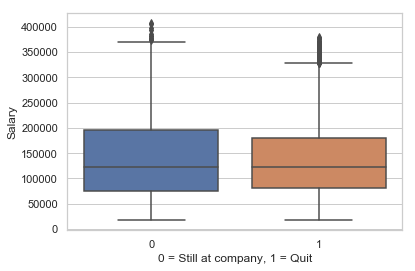

In [61]:
#Look at quit rates by salary 
ax = sns.boxplot(x='quit_binary', y='salary', data=employee_data)
ax.set(xlabel='0 = Still at company, 1 = Quit', ylabel='Salary')

[<matplotlib.text.Text at 0x11b7bdb00>, <matplotlib.text.Text at 0x11ba5fc50>]

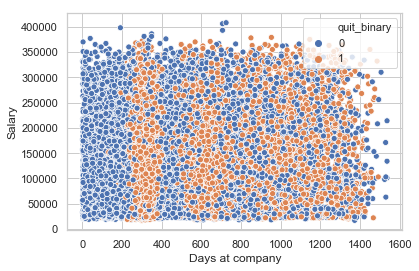

In [62]:
#Look at quit rates by salary (scatterplot) 
ax = sns.scatterplot(x =round(pd.to_numeric(employee_data.tenure)/1e14), y='salary', hue='quit_binary', data=employee_data)
ax.set(xlabel='Days at company', ylabel='Salary')

[<matplotlib.text.Text at 0x11be0a908>, <matplotlib.text.Text at 0x11b06c128>]

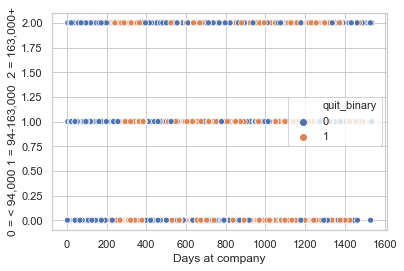

In [63]:
#Look at quit rates by salary level
#Low = < 94,000
#Mid = 94,000 - 163,000
#High = 163,000 +
employee_data['salary_level'] = pd.qcut(employee_data.salary, 3, labels=(0,1,2))
ax = sns.scatterplot(x =round(pd.to_numeric(employee_data.tenure)/1e14), y='salary_level', hue='quit_binary', data=employee_data)
ax.set(xlabel='Days at company', ylabel='0 = < 94,000 1 = 94-163,000  2 = 163,000+')

## Survival Analysis

#### This section models the time for an employee to quit using a Kaplan Meier analysis. From it, we learn that:
1. Over all the data, the probability that an employee is still at their job descreases linearly with time at a company, with there being a 50% chance that an employee is at their job after 2 years, and almost a 0% chance after 4 years.
2. This relationship is similiar across departments and salary, however, differs again by company. At company 11, employees stay longer (with a 50% chance that an employee is at their job within 3 years) even though many end up quitting. At Company 12, employees leave at a faster rate than the average. 
3. Looking at the company level, there is a difference in the employee retention rate by department. Therefore, I create a variable that is an interaction between the company ID and the department category. 

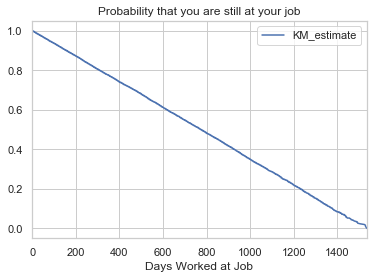

In [27]:
from lifelines import KaplanMeierFitter
from lifelines.utils import datetimes_to_durations

T = employee_data['tenure_int']
E = employee_data['survival']

kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)

kmf.survival_function_.plot()
plt.title('Probability that you are still at your job');
plt.xlabel('Days Worked at Job')

In [12]:
print("50% chance of employee quitting after " + str(kmf.median_) + ' days')

50% chance of employee quitting after 773.0 days


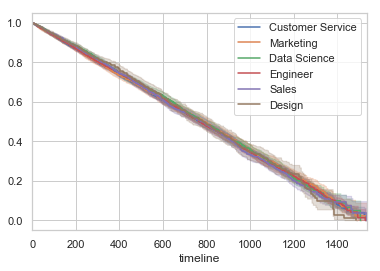

In [13]:
#Probability that you are still at your job by department
cust_service = (employee_data["dept"] == "customer_service")
marketing = (employee_data["dept"] == "marketing")
data_science = (employee_data["dept"] == "data_science")
engineer = (employee_data["dept"] == "engineer")
sales = (employee_data["dept"] == "sales")
design = (employee_data["dept"] == "design")

ax = plt.subplot(111)

kmf.fit(T[cust_service], event_observed=E[cust_service], label="Customer Service")
kmf.plot(ax=ax)
kmf.fit(T[marketing], event_observed=E[marketing], label="Marketing")
kmf.plot(ax=ax)
kmf.fit(T[data_science], event_observed=E[data_science], label="Data Science")
kmf.plot(ax=ax)
kmf.fit(T[engineer], event_observed=E[engineer], label="Engineer")
kmf.plot(ax=ax)
kmf.fit(T[sales], event_observed=E[sales], label="Sales")
kmf.plot(ax=ax)
kmf.fit(T[design], event_observed=E[design], label="Design")
kmf.plot(ax=ax)

Low Salary: 50% chance of employee quitting after 767.0 days
Mid Salary: 50% chance of employee quitting after 785.0 days
High Salary: 50% chance of employee quitting after 773.0 days


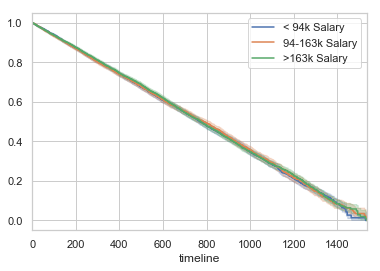

In [14]:
#Probability that you are still at your job by salary level
low_salary = (employee_data["salary_level"] == 0)
mid_salary = (employee_data["salary_level"] == 1)
high_salary = (employee_data["salary_level"] == 2)

ax = plt.subplot(111)

kmf.fit(T[low_salary], event_observed=E[low_salary], label="< 94k Salary ")
print("Low Salary: 50% chance of employee quitting after " + str(kmf.median_) + ' days')
kmf.plot(ax=ax)
kmf.fit(T[mid_salary], event_observed=E[mid_salary], label="94-163k Salary")
print("Mid Salary: 50% chance of employee quitting after " + str(kmf.median_) + ' days')
kmf.plot(ax=ax)
kmf.fit(T[high_salary], event_observed=E[high_salary], label=">163k Salary")
print("High Salary: 50% chance of employee quitting after " + str(kmf.median_) + ' days')
kmf.plot(ax=ax)

Company 1: 50% chance of employee quitting after 767.0 days
Company 2: 50% chance of employee quitting after 773.0 days
Company 3: 50% chance of employee quitting after 785.0 days
Company 4: 50% chance of employee quitting after 761.0 days
Company 5: 50% chance of employee quitting after 785.0 days
Company 6: 50% chance of employee quitting after 785.0 days
Company 7: 50% chance of employee quitting after 785.0 days
Company 8: 50% chance of employee quitting after 785.0 days
Company 9: 50% chance of employee quitting after 767.0 days
Company 10: 50% chance of employee quitting after 796.0 days
Company 11: 50% chance of employee quitting after 1051.0 days
Company 12: 50% chance of employee quitting after 627.0 days


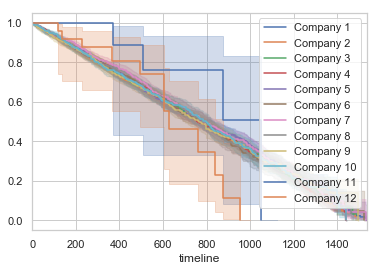

In [15]:
#Probability that you are still at your job by company
company_1 = (employee_data["company_id"] == 1)
company_2 = (employee_data["company_id"] == 2)
company_3 = (employee_data["company_id"] == 3)
company_4 = (employee_data["company_id"] == 4)
company_5 = (employee_data["company_id"] == 5)
company_6 = (employee_data["company_id"] == 6)
company_7 = (employee_data["company_id"] == 7)
company_8 = (employee_data["company_id"] == 8)
company_9 = (employee_data["company_id"] == 9)
company_10 = (employee_data["company_id"] == 10)
company_11 = (employee_data["company_id"] == 11)
company_12 = (employee_data["company_id"] == 12)

ax = plt.subplot(111)

kmf.fit(T[company_1], event_observed=E[company_1], label="Company 1")
print("Company 1: 50% chance of employee quitting after " + str(kmf.median_) + ' days')
kmf.plot(ax=ax)
kmf.fit(T[company_2], event_observed=E[company_2], label="Company 2")
print("Company 2: 50% chance of employee quitting after " + str(kmf.median_) + ' days')
kmf.plot(ax=ax)
kmf.fit(T[company_3], event_observed=E[company_3], label="Company 3")
print("Company 3: 50% chance of employee quitting after " + str(kmf.median_) + ' days')
kmf.plot(ax=ax)
kmf.fit(T[company_4], event_observed=E[company_4], label="Company 4")
print("Company 4: 50% chance of employee quitting after " + str(kmf.median_) + ' days')
kmf.plot(ax=ax)
kmf.fit(T[company_5], event_observed=E[company_5], label="Company 5")
print("Company 5: 50% chance of employee quitting after " + str(kmf.median_) + ' days')
kmf.plot(ax=ax)
kmf.fit(T[company_6], event_observed=E[company_6], label="Company 6")
print("Company 6: 50% chance of employee quitting after " + str(kmf.median_) + ' days')
kmf.plot(ax=ax)
kmf.fit(T[company_7], event_observed=E[company_7], label="Company 7")
print("Company 7: 50% chance of employee quitting after " + str(kmf.median_) + ' days')
kmf.plot(ax=ax)
kmf.fit(T[company_8], event_observed=E[company_8], label="Company 8")
print("Company 8: 50% chance of employee quitting after " + str(kmf.median_) + ' days')
kmf.plot(ax=ax)
kmf.fit(T[company_9], event_observed=E[company_9], label="Company 9")
print("Company 9: 50% chance of employee quitting after " + str(kmf.median_) + ' days')
kmf.plot(ax=ax)
kmf.fit(T[company_10], event_observed=E[company_10], label="Company 10")
print("Company 10: 50% chance of employee quitting after " + str(kmf.median_) + ' days')
kmf.plot(ax=ax)
kmf.fit(T[company_11], event_observed=E[company_11], label="Company 11")
print("Company 11: 50% chance of employee quitting after " + str(kmf.median_) + ' days')
kmf.plot(ax=ax)
kmf.fit(T[company_12], event_observed=E[company_12], label="Company 12")
print("Company 12: 50% chance of employee quitting after " + str(kmf.median_) + ' days')
kmf.plot(ax=ax)

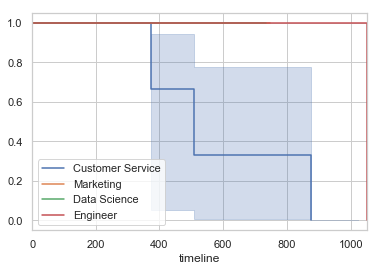

In [16]:
#Probability that you are still at your job by department at Company 11

ax = plt.subplot(111)

kmf.fit(T[(cust_service) & (company_11)], event_observed=E[(cust_service) & (company_11)], label="Customer Service")
kmf.plot(ax=ax)
kmf.fit(T[(marketing) & (company_11)], event_observed=E[(marketing) & (company_11)], label="Marketing")
kmf.plot(ax=ax)
kmf.fit(T[(data_science) & (company_11)], event_observed=E[(data_science) & (company_11)], label="Data Science")
kmf.plot(ax=ax)
kmf.fit(T[(engineer) & (company_11)], event_observed=E[(engineer) & (company_11)], label="Engineer")
kmf.plot(ax=ax)

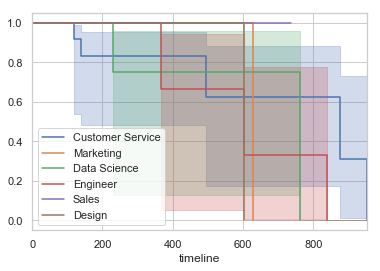

In [17]:
#Probability that you are still at your job by department at Company 12

ax = plt.subplot(111)

kmf.fit(T[(cust_service) & (company_12)], event_observed=E[(cust_service) & (company_12)], label="Customer Service")
kmf.plot(ax=ax)
kmf.fit(T[(marketing) & (company_12)], event_observed=E[(marketing) & (company_12)], label="Marketing")
kmf.plot(ax=ax)
kmf.fit(T[(data_science) & (company_12)], event_observed=E[(data_science) & (company_12)], label="Data Science")
kmf.plot(ax=ax)
kmf.fit(T[(engineer) & (company_12)], event_observed=E[(engineer) & (company_12)], label="Engineer")
kmf.plot(ax=ax)
kmf.fit(T[(sales) & (company_12)], event_observed=E[(sales) & (company_12)], label="Sales")
kmf.plot(ax=ax)
kmf.fit(T[(design) & (company_12)], event_observed=E[(design) & (company_12)], label="Design")
kmf.plot(ax=ax)

## Model

#### The model below is a cox proportional hazards model that evaluates the likelihood of an employee still being at their job after X days of employement using the following features:
1. The log of their salary
2. The log of their years of seniority
3. The type of department they belong to
4. The company they work for
5. An interaction term between company and department
6. The number of employees in the company

#### It is trained on 80% of the data, and then predicts the likelihood that the other 20% of employees will still be working at the company in 1, 2, 3, and 4 years, given the characteristics above
#### The main assumption of the model is that time is the most important predictor of when an employee will leave, which makes sense. Other than that, the cox model shows that salary and seniority also matter. If I could have one other variable, it would be employee satisifcation (e.g., Glassdoor) or the number of times an employee has been promoted.

In [47]:
#Some variation by company and department
#Make interaction variable between department and company number
employee_data['ln_salary'] = np.log(employee_data.salary)
employee_data['ln_seniority'] = np.log(employee_data.seniority)
employee_data['dept_code'] = employee_data.dept.astype('category').cat.codes+1
employee_data['dept_company_interaction'] = employee_data.company_id*employee_data.dept.astype('category').cat.codes
employee_data = employee_data.merge(pd.DataFrame(employee_data.groupby('company_id').agg('count').dept).rename(columns={'dept': 'num_employees'}).reset_index(), on='company_id')


In [51]:
from lifelines import CoxPHFitter
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(employee_data[['ln_salary', 'ln_seniority','dept_code', 'dept_company_interaction', 'company_id','tenure_int', 'quit_binary', 'num_employees']], test_size=0.2, random_state=42)

cph = CoxPHFitter()
cph.fit(X_train, duration_col='tenure_int', event_col='quit_binary', show_progress=True)

cph.print_summary()

Iteration 1: norm_delta = 0.14264, step_size = 0.9500, ll = -95100.23781, newton_decrement = 30.39196, seconds_since_start = 0.4
Iteration 2: norm_delta = 0.00963, step_size = 0.9500, ll = -95069.70495, newton_decrement = 0.12462, seconds_since_start = 1.0
Iteration 3: norm_delta = 0.00049, step_size = 0.9500, ll = -95069.58055, newton_decrement = 0.00033, seconds_since_start = 1.4
Iteration 4: norm_delta = 0.00003, step_size = 1.0000, ll = -95069.58023, newton_decrement = 0.00000, seconds_since_start = 1.9
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, ll = -95069.58023, newton_decrement = 0.00000, seconds_since_start = 2.3
Convergence completed after 5 iterations.
<lifelines.CoxPHFitter: fitted with 19760 observations, 8988 censored>
      duration col = 'tenure_int'
         event col = 'quit_binary'
number of subjects = 19760
  number of events = 10772
    log-likelihood = -95069.58
  time fit was run = 2019-02-20 20:01:13 UTC

---
                          coef  exp(coef) 

In [64]:
pd.DataFrame(cph.predict_survival_function(X_test, times=[365, 730, 1095, 1460]).T).rename(columns={365:'1 year', 730:'2 years',1095:'3 years',1460:'4 years' })

,1 year,2 years,3 years,4 years
16348,0.688507,0.436675,0.244203,0.031192
12311,0.650588,0.385072,0.197162,0.018428
13229,0.643370,0.375652,0.189026,0.016613
4421,0.652341,0.387379,0.199176,0.018894
1456,0.630502,0.359176,0.175138,0.013770
11024,0.660872,0.398715,0.209195,0.021318
9401,0.701807,0.455622,0.262504,0.037260
4258,0.637648,0.368274,0.182753,0.015290
6864,0.652222,0.387222,0.199038,0.018862
2564,0.635963,0.366118,0.180937,0.014919
